# Modeling

## Contents  

    1. Library Load   
    2. Data Load and Check 
    3. Data Preprocessing
        3-1. 1일전,2일전 일사량, 발전량 데이터 추가하기  
        3-2. 변수선택  
        3-3. 카테고리변수 더미화
            - 다중공선성 체크
        3-4. 연속형변수 minmax scaling  
        3-5. Dataset Split
    4. Modeling
        4-1. Linear Regression
        4-2. Decision Tree
        4-3. RandomForest
        4-4. SVM(LinearSVR)
        4-5. XGBoost
        4-6. AdaBoost
        4-7. Neural Network
        4-8. Cross Validation
        4-9. Parameter Tuning  
            4-9-1. RandomForest  
            4-9-2. XGBoost  
            4-9-3. Freature Importances
                    

## 1. Library Load

In [1]:
# 기본도구
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 모델선택
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

# 방법론
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
import statsmodels.formula.api as sm
import xgboost as xg
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

# 도구
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from dmba import regressionSummary, exhaustive_search
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 테마
sns.set(style='white', context='notebook', palette='deep')
# 최대출력 컬럼 조절
pd.set_option("display.max_columns", 100)

## 2. Data Load and Check

In [2]:
df = pd.read_csv('donghae_solar_power_dataset2018_rev6.csv', index_col=0)
#check = pd.read_csv('donghae_solar_power_dataset2018_rev6.csv', index_col=0)

In [3]:
df.head()

,date,hour,humidity,rain,rain_type,temp,thunder,wind_angle,wind_direction,wind_velo,sky_con,solar_radiation_normal,season,SO2,CO,O3,NO2,PM10,PM25,power,date_time,solar_radiation
0,2018.1.1,6,17,0.0,0,4.7,0,289,1,2.8,1,0.00,0,0.002,0.4,0.034,0.005,17.0,12.0,0,2018-01-01-6,0.00
1,2018.1.1,7,19,0.0,0,3.4,0,278,1,2.7,1,0.00,0,0.003,0.4,0.032,0.006,19.0,12.0,0,2018-01-01-7,0.00
2,2018.1.1,8,14,0.0,0,2.7,0,268,8,2.3,1,0.00,0,0.002,0.5,0.030,0.009,19.0,12.0,7,2018-01-01-8,0.01
3,2018.1.1,9,18,0.0,0,2.3,0,268,8,2.3,2,4.78,0,0.003,0.5,0.031,0.008,17.0,13.0,245,2018-01-01-9,0.39
4,2018.1.1,10,20,0.0,0,2.1,0,250,8,3.0,2,17.79,0,0.003,0.5,0.033,0.006,14.0,11.5,776,2018-01-01-10,1.01


In [4]:
df.columns

Index(['date', 'hour', 'humidity', 'rain', 'rain_type', 'temp', 'thunder',
       'wind_angle', 'wind_direction', 'wind_velo', 'sky_con',
       'solar_radiation_normal', 'season', 'SO2', 'CO', 'O3', 'NO2', 'PM10',
       'PM25', 'power', 'date_time', 'solar_radiation'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5475 entries, 0 to 5474
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    5475 non-null   object 
 1   hour                    5475 non-null   int64  
 2   humidity                5475 non-null   int64  
 3   rain                    5475 non-null   float64
 4   rain_type               5475 non-null   int64  
 5   temp                    5475 non-null   float64
 6   thunder                 5475 non-null   int64  
 7   wind_angle              5475 non-null   int64  
 8   wind_direction          5475 non-null   int64  
 9   wind_velo               5475 non-null   float64
 10  sky_con                 5475 non-null   int64  
 11  solar_radiation_normal  5475 non-null   float64
 12  season                  5475 non-null   int64  
 13  SO2                     5475 non-null   float64
 14  CO                      5475 non-null   

In [6]:
df.isnull().sum()

date                      0
hour                      0
humidity                  0
rain                      0
rain_type                 0
temp                      0
thunder                   0
wind_angle                0
wind_direction            0
wind_velo                 0
sky_con                   0
solar_radiation_normal    0
season                    0
SO2                       0
CO                        0
O3                        0
NO2                       0
PM10                      0
PM25                      0
power                     0
date_time                 0
solar_radiation           0
dtype: int64

In [7]:
df.describe()

,hour,humidity,rain,rain_type,temp,thunder,wind_angle,wind_direction,wind_velo,sky_con,solar_radiation_normal,season,SO2,CO,O3,NO2,PM10,PM25,power,solar_radiation
count,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000
mean,13.000000,64.966575,0.137534,0.107580,12.476402,0.462283,213.375342,5.118904,1.856840,2.622283,197.144701,1.517808,0.002226,0.368840,0.035455,0.015341,33.435616,18.361297,344.679452,1.000458
std,4.320888,23.388769,0.942363,0.346609,9.182789,1.047376,92.680642,2.668768,1.217721,1.292094,260.771845,1.114312,0.001349,0.255194,0.019416,0.012101,22.742565,11.680583,390.048235,1.041250
min,6.000000,8.000000,0.000000,0.000000,-11.900000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.001000,0.100000,0.001000,0.001000,2.000000,1.000000,0.000000,0.000000
25%,9.000000,46.000000,0.000000,0.000000,5.500000,0.000000,187.500000,2.000000,1.000000,1.000000,0.000000,1.000000,0.001000,0.200000,0.023000,0.007000,18.000000,10.000000,18.000000,0.050000
50%,13.000000,69.000000,0.000000,0.000000,13.000000,0.000000,225.000000,7.000000,1.600000,3.000000,16.360000,2.000000,0.002000,0.300000,0.035000,0.011000,28.000000,15.000000,301.000000,0.600000
75%,17.000000,86.000000,0.000000,0.000000,20.000000,0.000000,273.000000,7.000000,2.400000,4.000000,388.010000,3.000000,0.003000,0.400000,0.046000,0.020000,43.000000,24.000000,410.000000,1.770000
max,20.000000,100.000000,32.000000,3.000000,32.500000,4.000000,360.000000,8.000000,10.100000,4.000000,948.440000,3.000000,0.014000,3.700000,0.136000,0.081000,210.000000,98.000000,1949.000000,3.990000


## 3. Data Preprocessing
    3-1. 1일전,2일전 일사량, 발전량 데이터 추가하기  
    3-2. 변수선택  
    3-3. 카테고리변수 더미화 
    3-4. 연속형변수 minmax scaling

### 3-1. 1일전, 2일전, 일사량, 발전량 데이터 추가하기

In [8]:
# 날짜 타입으로 변경
df.date = pd.to_datetime(df.date)

In [9]:
# 1일전
df2 = df.shift(15)
df2.iloc[10:18]

,date,hour,humidity,rain,rain_type,temp,thunder,wind_angle,wind_direction,wind_velo,sky_con,solar_radiation_normal,season,SO2,CO,O3,NO2,PM10,PM25,power,date_time,solar_radiation
10,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,2018-01-01,6.0,17.0,0.0,0.0,4.7,0.0,289.0,1.0,2.8,1.0,0.0,0.0,0.002,0.4,0.034,0.005,17.0,12.0,0.0,2018-01-01-6,0.00
16,2018-01-01,7.0,19.0,0.0,0.0,3.4,0.0,278.0,1.0,2.7,1.0,0.0,0.0,0.003,0.4,0.032,0.006,19.0,12.0,0.0,2018-01-01-7,0.00
17,2018-01-01,8.0,14.0,0.0,0.0,2.7,0.0,268.0,8.0,2.3,1.0,0.0,0.0,0.002,0.5,0.030,0.009,19.0,12.0,7.0,2018-01-01-8,0.01


In [10]:
df2.columns

Index(['date', 'hour', 'humidity', 'rain', 'rain_type', 'temp', 'thunder',
       'wind_angle', 'wind_direction', 'wind_velo', 'sky_con',
       'solar_radiation_normal', 'season', 'SO2', 'CO', 'O3', 'NO2', 'PM10',
       'PM25', 'power', 'date_time', 'solar_radiation'],
      dtype='object')

In [11]:
df2 = df2[['power','solar_radiation', 'date', 'hour', 'date_time']]

In [12]:
df2.columns

Index(['power', 'solar_radiation', 'date', 'hour', 'date_time'], dtype='object')

In [13]:
df2.columns =['power_tl1', 'solar_radiation_tl1', 'date', 'hour', 'date_time']

In [14]:
df2.head()

,power_tl1,solar_radiation_tl1,date,hour,date_time
0,NaN,NaN,NaT,NaN,NaN
1,NaN,NaN,NaT,NaN,NaN
2,NaN,NaN,NaT,NaN,NaN
3,NaN,NaN,NaT,NaN,NaN
4,NaN,NaN,NaT,NaN,NaN


In [15]:
df2.head(20)

,power_tl1,solar_radiation_tl1,date,hour,date_time
0,NaN,NaN,NaT,NaN,NaN
1,NaN,NaN,NaT,NaN,NaN
2,NaN,NaN,NaT,NaN,NaN
3,NaN,NaN,NaT,NaN,NaN
4,NaN,NaN,NaT,NaN,NaN
5,NaN,NaN,NaT,NaN,NaN
6,NaN,NaN,NaT,NaN,NaN
7,NaN,NaN,NaT,NaN,NaN
8,NaN,NaN,NaT,NaN,NaN
9,NaN,NaN,NaT,NaN,NaN


In [16]:
df.head(20)

,date,hour,humidity,rain,rain_type,temp,thunder,wind_angle,wind_direction,wind_velo,sky_con,solar_radiation_normal,season,SO2,CO,O3,NO2,PM10,PM25,power,date_time,solar_radiation
0,2018-01-01,6,17,0.0,0,4.7,0,289,1,2.8,1,0.00,0,0.002,0.4,0.034,0.005,17.0,12.0,0,2018-01-01-6,0.00
1,2018-01-01,7,19,0.0,0,3.4,0,278,1,2.7,1,0.00,0,0.003,0.4,0.032,0.006,19.0,12.0,0,2018-01-01-7,0.00
2,2018-01-01,8,14,0.0,0,2.7,0,268,8,2.3,1,0.00,0,0.002,0.5,0.030,0.009,19.0,12.0,7,2018-01-01-8,0.01
3,2018-01-01,9,18,0.0,0,2.3,0,268,8,2.3,2,4.78,0,0.003,0.5,0.031,0.008,17.0,13.0,245,2018-01-01-9,0.39
4,2018-01-01,10,20,0.0,0,2.1,0,250,8,3.0,2,17.79,0,0.003,0.5,0.033,0.006,14.0,11.5,776,2018-01-01-10,1.01
5,2018-01-01,11,26,0.0,0,2.1,0,259,8,3.8,2,291.69,0,0.002,0.5,0.035,0.007,19.0,10.0,1361,2018-01-01-11,1.52
6,2018-01-01,12,27,0.0,0,2.2,0,264,8,3.8,2,353.29,0,0.002,0.4,0.035,0.006,16.0,13.0,1681,2018-01-01-12,1.85
7,2018-01-01,13,27,0.0,0,1.9,0,255,8,3.1,2,179.65,0,0.002,0.4,0.037,0.006,10.0,11.0,1733,2018-01-01-13,1.97
8,2018-01-01,14,29,0.0,0,1.6,0,251,8,2.4,2,46.11,0,0.002,0.4,0.038,0.005,11.0,11.0,1645,2018-01-01-14,1.85
9,2018-01-01,15,28,0.0,0,2.0,0,265,8,3.6,2,188.56,0,0.002,0.4,0.037,0.006,12.0,9.0,1231,2018-01-01-15,1.48


In [17]:
# 2일전 
df3 = df.shift(30)
df3.iloc[26:34]

,date,hour,humidity,rain,rain_type,temp,thunder,wind_angle,wind_direction,wind_velo,sky_con,solar_radiation_normal,season,SO2,CO,O3,NO2,PM10,PM25,power,date_time,solar_radiation
26,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,2018-01-01,6.0,17.0,0.0,0.0,4.7,0.0,289.0,1.0,2.8,1.0,0.00,0.0,0.002,0.4,0.034,0.005,17.0,12.0,0.0,2018-01-01-6,0.00
31,2018-01-01,7.0,19.0,0.0,0.0,3.4,0.0,278.0,1.0,2.7,1.0,0.00,0.0,0.003,0.4,0.032,0.006,19.0,12.0,0.0,2018-01-01-7,0.00
32,2018-01-01,8.0,14.0,0.0,0.0,2.7,0.0,268.0,8.0,2.3,1.0,0.00,0.0,0.002,0.5,0.030,0.009,19.0,12.0,7.0,2018-01-01-8,0.01
33,2018-01-01,9.0,18.0,0.0,0.0,2.3,0.0,268.0,8.0,2.3,2.0,4.78,0.0,0.003,0.5,0.031,0.008,17.0,13.0,245.0,2018-01-01-9,0.39


In [18]:
df3 = df3[['power', 'solar_radiation', 'date', 'hour', 'date_time']]

In [19]:
df3.columns

Index(['power', 'solar_radiation', 'date', 'hour', 'date_time'], dtype='object')

In [20]:
df3.columns =['power_tl2', 'solar_radiation_tl2', 'date', 'hour', 'date_time']

In [21]:
df3.head()

,power_tl2,solar_radiation_tl2,date,hour,date_time
0,NaN,NaN,NaT,NaN,NaN
1,NaN,NaN,NaT,NaN,NaN
2,NaN,NaN,NaT,NaN,NaN
3,NaN,NaN,NaT,NaN,NaN
4,NaN,NaN,NaT,NaN,NaN


In [22]:
df3[25:35]

,power_tl2,solar_radiation_tl2,date,hour,date_time
25,NaN,NaN,NaT,NaN,NaN
26,NaN,NaN,NaT,NaN,NaN
27,NaN,NaN,NaT,NaN,NaN
28,NaN,NaN,NaT,NaN,NaN
29,NaN,NaN,NaT,NaN,NaN
30,0.0,0.00,2018-01-01,6.0,2018-01-01-6
31,0.0,0.00,2018-01-01,7.0,2018-01-01-7
32,7.0,0.01,2018-01-01,8.0,2018-01-01-8
33,245.0,0.39,2018-01-01,9.0,2018-01-01-9
34,776.0,1.01,2018-01-01,10.0,2018-01-01-10


In [23]:
df=pd.concat([df,df2[['power_tl1', 'solar_radiation_tl1']]], axis=1)

In [24]:
df.head(20)

,date,hour,humidity,rain,rain_type,temp,thunder,wind_angle,wind_direction,wind_velo,sky_con,solar_radiation_normal,season,SO2,CO,O3,NO2,PM10,PM25,power,date_time,solar_radiation,power_tl1,solar_radiation_tl1
0,2018-01-01,6,17,0.0,0,4.7,0,289,1,2.8,1,0.00,0,0.002,0.4,0.034,0.005,17.0,12.0,0,2018-01-01-6,0.00,NaN,NaN
1,2018-01-01,7,19,0.0,0,3.4,0,278,1,2.7,1,0.00,0,0.003,0.4,0.032,0.006,19.0,12.0,0,2018-01-01-7,0.00,NaN,NaN
2,2018-01-01,8,14,0.0,0,2.7,0,268,8,2.3,1,0.00,0,0.002,0.5,0.030,0.009,19.0,12.0,7,2018-01-01-8,0.01,NaN,NaN
3,2018-01-01,9,18,0.0,0,2.3,0,268,8,2.3,2,4.78,0,0.003,0.5,0.031,0.008,17.0,13.0,245,2018-01-01-9,0.39,NaN,NaN
4,2018-01-01,10,20,0.0,0,2.1,0,250,8,3.0,2,17.79,0,0.003,0.5,0.033,0.006,14.0,11.5,776,2018-01-01-10,1.01,NaN,NaN
5,2018-01-01,11,26,0.0,0,2.1,0,259,8,3.8,2,291.69,0,0.002,0.5,0.035,0.007,19.0,10.0,1361,2018-01-01-11,1.52,NaN,NaN
6,2018-01-01,12,27,0.0,0,2.2,0,264,8,3.8,2,353.29,0,0.002,0.4,0.035,0.006,16.0,13.0,1681,2018-01-01-12,1.85,NaN,NaN
7,2018-01-01,13,27,0.0,0,1.9,0,255,8,3.1,2,179.65,0,0.002,0.4,0.037,0.006,10.0,11.0,1733,2018-01-01-13,1.97,NaN,NaN
8,2018-01-01,14,29,0.0,0,1.6,0,251,8,2.4,2,46.11,0,0.002,0.4,0.038,0.005,11.0,11.0,1645,2018-01-01-14,1.85,NaN,NaN
9,2018-01-01,15,28,0.0,0,2.0,0,265,8,3.6,2,188.56,0,0.002,0.4,0.037,0.006,12.0,9.0,1231,2018-01-01-15,1.48,NaN,NaN


In [25]:
df=pd.concat([df,df3[['power_tl2', 'solar_radiation_tl2']]], axis=1)

In [26]:
df.head()

,date,hour,humidity,rain,rain_type,temp,thunder,wind_angle,wind_direction,wind_velo,sky_con,solar_radiation_normal,season,SO2,CO,O3,NO2,PM10,PM25,power,date_time,solar_radiation,power_tl1,solar_radiation_tl1,power_tl2,solar_radiation_tl2
0,2018-01-01,6,17,0.0,0,4.7,0,289,1,2.8,1,0.00,0,0.002,0.4,0.034,0.005,17.0,12.0,0,2018-01-01-6,0.00,NaN,NaN,NaN,NaN
1,2018-01-01,7,19,0.0,0,3.4,0,278,1,2.7,1,0.00,0,0.003,0.4,0.032,0.006,19.0,12.0,0,2018-01-01-7,0.00,NaN,NaN,NaN,NaN
2,2018-01-01,8,14,0.0,0,2.7,0,268,8,2.3,1,0.00,0,0.002,0.5,0.030,0.009,19.0,12.0,7,2018-01-01-8,0.01,NaN,NaN,NaN,NaN
3,2018-01-01,9,18,0.0,0,2.3,0,268,8,2.3,2,4.78,0,0.003,0.5,0.031,0.008,17.0,13.0,245,2018-01-01-9,0.39,NaN,NaN,NaN,NaN
4,2018-01-01,10,20,0.0,0,2.1,0,250,8,3.0,2,17.79,0,0.003,0.5,0.033,0.006,14.0,11.5,776,2018-01-01-10,1.01,NaN,NaN,NaN,NaN


In [27]:
df.describe()

,hour,humidity,rain,rain_type,temp,thunder,wind_angle,wind_direction,wind_velo,sky_con,solar_radiation_normal,season,SO2,CO,O3,NO2,PM10,PM25,power,solar_radiation,power_tl1,solar_radiation_tl1,power_tl2,solar_radiation_tl2
count,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5460.000000,5460.000000,5445.000000,5445.000000
mean,13.000000,64.966575,0.137534,0.107580,12.476402,0.462283,213.375342,5.118904,1.856840,2.622283,197.144701,1.517808,0.002226,0.368840,0.035455,0.015341,33.435616,18.361297,344.679452,1.000458,344.885531,1.001161,345.014141,1.001846
std,4.320888,23.388769,0.942363,0.346609,9.182789,1.047376,92.680642,2.668768,1.217721,1.292094,260.771845,1.114312,0.001349,0.255194,0.019416,0.012101,22.742565,11.680583,390.048235,1.041250,390.247072,1.041819,390.389880,1.042389
min,6.000000,8.000000,0.000000,0.000000,-11.900000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.001000,0.100000,0.001000,0.001000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,46.000000,0.000000,0.000000,5.500000,0.000000,187.500000,2.000000,1.000000,1.000000,0.000000,1.000000,0.001000,0.200000,0.023000,0.007000,18.000000,10.000000,18.000000,0.050000,18.000000,0.050000,18.000000,0.060000
50%,13.000000,69.000000,0.000000,0.000000,13.000000,0.000000,225.000000,7.000000,1.600000,3.000000,16.360000,2.000000,0.002000,0.300000,0.035000,0.011000,28.000000,15.000000,301.000000,0.600000,301.000000,0.600000,301.000000,0.600000
75%,17.000000,86.000000,0.000000,0.000000,20.000000,0.000000,273.000000,7.000000,2.400000,4.000000,388.010000,3.000000,0.003000,0.400000,0.046000,0.020000,43.000000,24.000000,410.000000,1.770000,410.000000,1.770000,410.000000,1.770000
max,20.000000,100.000000,32.000000,3.000000,32.500000,4.000000,360.000000,8.000000,10.100000,4.000000,948.440000,3.000000,0.014000,3.700000,0.136000,0.081000,210.000000,98.000000,1949.000000,3.990000,1949.000000,3.990000,1949.000000,3.990000


In [28]:
df=df.dropna()

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5445 entries, 30 to 5474
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    5445 non-null   datetime64[ns]
 1   hour                    5445 non-null   int64         
 2   humidity                5445 non-null   int64         
 3   rain                    5445 non-null   float64       
 4   rain_type               5445 non-null   int64         
 5   temp                    5445 non-null   float64       
 6   thunder                 5445 non-null   int64         
 7   wind_angle              5445 non-null   int64         
 8   wind_direction          5445 non-null   int64         
 9   wind_velo               5445 non-null   float64       
 10  sky_con                 5445 non-null   int64         
 11  solar_radiation_normal  5445 non-null   float64       
 12  season                  5445 non-null   int64  

In [30]:
# 인덱스 바뀜
df.reset_index(drop=True, inplace=True)

In [31]:
df.columns

Index(['date', 'hour', 'humidity', 'rain', 'rain_type', 'temp', 'thunder',
       'wind_angle', 'wind_direction', 'wind_velo', 'sky_con',
       'solar_radiation_normal', 'season', 'SO2', 'CO', 'O3', 'NO2', 'PM10',
       'PM25', 'power', 'date_time', 'solar_radiation', 'power_tl1',
       'solar_radiation_tl1', 'power_tl2', 'solar_radiation_tl2'],
      dtype='object')

### 3-2. 변수 선택

In [32]:
# 다 포함 
#df = df[['hour', 'humidity', 'rain', 'rain_type', 'temp', 'thunder','wind_direction',
#         'wind_velo', 'sky_con','solar_radiation_normal', 'season','O3', 'NO2', 'PM10', 'power']]

# 천둥빼기
#df = df[['hour', 'humidity', 'rain', 'rain_type', 'temp','wind_direction',
#         'wind_velo', 'sky_con','solar_radiation_normal', 'season','O3', 'NO2', 'PM10', 'power']]

# 일사량 빼기
#df = df[['hour', 'humidity', 'rain', 'rain_type', 'temp','wind_direction',
#         'wind_velo', 'sky_con', 'season','O3', 'NO2', 'PM10', 'power']]

# 하루전 이틀전 power, solar 데이터 넣기
# df=df[['hour', 'humidity', 'rain', 'rain_type', 'temp', 'wind_direction', 'wind_velo', 'sky_con',
#        'solar_radiation_normal', 'season','O3', 'NO2',
#        'PM25', 'power_tl1',
#        'solar_radiation_normal_tl1', 'power_tl2',
#        'solar_radiation_normal_tl2','power']]

#하루전 이틀전 power, solar 데이터 넣기
df=df[['hour', 'humidity', 'rain', 'rain_type', 'temp', 'wind_direction', 'wind_velo', 'sky_con',
       'solar_radiation', 'season','O3', 'NO2',
       'PM25', 'power_tl1',
       'solar_radiation_tl1', 'power_tl2',
       'solar_radiation_tl2','power']]
#
# power 하루전 이틀전 넣기
# df=df[['hour', 'humidity', 'rain', 'rain_type', 'temp', 'wind_direction', 'wind_velo', 'sky_con',
#        'solar_radiation', 'season','O3', 'NO2',
#        'PM25','power_tl1','power_tl2', 'power']]

# 시간제외
# df=df[['humidity', 'rain', 'rain_type', 'temp', 'wind_direction', 'wind_velo', 'sky_con',
#        'solar_radiation', 'season','O3', 'NO2',
#        'PM25','power']]

# 온도 제외
# df=df[['hour', 'humidity', 'rain', 'rain_type', 'wind_direction', 'wind_velo', 'sky_con',
#        'solar_radiation', 'season','O3', 'NO2',
#        'PM25','power_tl1','power_tl2', 'power']]

In [33]:
df.head()

,hour,humidity,rain,rain_type,temp,wind_direction,wind_velo,sky_con,solar_radiation,season,O3,NO2,PM25,power_tl1,solar_radiation_tl1,power_tl2,solar_radiation_tl2,power
0,6,35,0.0,0,3.0,3,2.3,1,0.00,0,0.028,0.011,13.0,0.0,0.00,0.0,0.00,0
1,7,40,0.0,0,2.0,2,1.6,1,0.00,0,0.022,0.018,12.0,0.0,0.00,0.0,0.00,0
2,8,44,0.0,0,0.3,7,0.9,1,0.01,0,0.020,0.022,13.0,5.0,0.01,7.0,0.01,2
3,9,37,0.0,0,0.1,8,1.7,3,0.37,0,0.018,0.025,13.0,185.0,0.27,245.0,0.39,216
4,10,32,0.0,0,0.4,8,2.3,3,0.96,0,0.016,0.027,13.0,540.0,0.76,776.0,1.01,751


In [34]:
# rain log 변환 시도 -> 결과 변화 없음
# df.head()
# rain_log = np.log(df.rain+1)  # +1은 0 log0은 모두 -무한대이므로
# df.rain = rain_log

### 3-3. 카테고리변수 더미화

In [35]:
# 카테고리 변수로 변경
df['hour'] = df['hour'].astype('category')
df['season'] = df['season'].astype('category')
df['wind_direction'] = df['wind_direction'].astype('category')
df['sky_con'] = df['sky_con'].astype('category')
df['rain_type'] = df['rain_type'].astype('category')

# 천둥빼기
#df['thunder'] = df['thunder'].astype('category')

In [36]:
# 카테고리변수 더미화 시키기
df = pd.get_dummies(df, columns = ["hour"])
df = pd.get_dummies(df, columns = ["season"],drop_first=True)
df = pd.get_dummies(df, columns = ["wind_direction"],drop_first=True)
df = pd.get_dummies(df, columns = ["sky_con"],drop_first=True)
df = pd.get_dummies(df, columns = ["rain_type"],drop_first=True)
#천둥빼기
#df = pd.get_dummies(df, columns = ["thunder"])

In [37]:
df.head()

,humidity,rain,temp,wind_velo,solar_radiation,O3,NO2,PM25,power_tl1,solar_radiation_tl1,power_tl2,solar_radiation_tl2,power,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,season_1,season_2,season_3,wind_direction_2,wind_direction_3,wind_direction_4,wind_direction_5,wind_direction_6,wind_direction_7,wind_direction_8,sky_con_2,sky_con_3,sky_con_4,rain_type_1,rain_type_2,rain_type_3
0,35,0.0,3.0,2.3,0.00,0.028,0.011,13.0,0.0,0.00,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,40,0.0,2.0,1.6,0.00,0.022,0.018,12.0,0.0,0.00,0.0,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,44,0.0,0.3,0.9,0.01,0.020,0.022,13.0,5.0,0.01,7.0,0.01,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,37,0.0,0.1,1.7,0.37,0.018,0.025,13.0,185.0,0.27,245.0,0.39,216,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
4,32,0.0,0.4,2.3,0.96,0.016,0.027,13.0,540.0,0.76,776.0,1.01,751,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [38]:
# 다중공선성 체크
X_vif = df.drop(columns=['power'])

vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X_vif.values,i) for i in range(X_vif.shape[1])]
vif['features'] = X_vif.columns
vif

,VIF Factor,features
0,2.595656,humidity
1,1.238268,rain
2,3.246882,temp
3,1.331386,wind_velo
4,3.973651,solar_radiation
5,3.269056,O3
6,2.480140,NO2
7,1.690764,PM25
8,3.267092,power_tl1
9,4.907899,solar_radiation_tl1


In [39]:
df.columns

Index(['humidity', 'rain', 'temp', 'wind_velo', 'solar_radiation', 'O3', 'NO2',
       'PM25', 'power_tl1', 'solar_radiation_tl1', 'power_tl2',
       'solar_radiation_tl2', 'power', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'season_1',
       'season_2', 'season_3', 'wind_direction_2', 'wind_direction_3',
       'wind_direction_4', 'wind_direction_5', 'wind_direction_6',
       'wind_direction_7', 'wind_direction_8', 'sky_con_2', 'sky_con_3',
       'sky_con_4', 'rain_type_1', 'rain_type_2', 'rain_type_3'],
      dtype='object')

### 3-4. 연속형변수 minmax scaling

In [40]:
# minmax scaler
def my_minmax(data):
    numerator = data - np.min(data,0)
    denominator = np.max(data,0) - np.min(data,)
    
    return numerator / (denominator + 1e-7)

In [41]:
df.head()

,humidity,rain,temp,wind_velo,solar_radiation,O3,NO2,PM25,power_tl1,solar_radiation_tl1,power_tl2,solar_radiation_tl2,power,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,season_1,season_2,season_3,wind_direction_2,wind_direction_3,wind_direction_4,wind_direction_5,wind_direction_6,wind_direction_7,wind_direction_8,sky_con_2,sky_con_3,sky_con_4,rain_type_1,rain_type_2,rain_type_3
0,35,0.0,3.0,2.3,0.00,0.028,0.011,13.0,0.0,0.00,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,40,0.0,2.0,1.6,0.00,0.022,0.018,12.0,0.0,0.00,0.0,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,44,0.0,0.3,0.9,0.01,0.020,0.022,13.0,5.0,0.01,7.0,0.01,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,37,0.0,0.1,1.7,0.37,0.018,0.025,13.0,185.0,0.27,245.0,0.39,216,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
4,32,0.0,0.4,2.3,0.96,0.016,0.027,13.0,540.0,0.76,776.0,1.01,751,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [42]:
# 원래
df.iloc[:,13]
#테스트
# df.iloc[:,11]

0       1
1       0
2       0
3       0
4       0
       ..
5440    0
5441    0
5442    0
5443    0
5444    0
Name: hour_6, Length: 5445, dtype: uint8

In [43]:
#스케일링 적용 더미변수 제외
for i in range(12):
    df.iloc[:,i] = my_minmax(df.iloc[:,i])
    
# # 테스트

# for i in range(10):
#     df.iloc[:,i] = my_minmax(df.iloc[:,i])

In [44]:
df.head()

,humidity,rain,temp,wind_velo,solar_radiation,O3,NO2,PM25,power_tl1,solar_radiation_tl1,power_tl2,solar_radiation_tl2,power,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,season_1,season_2,season_3,wind_direction_2,wind_direction_3,wind_direction_4,wind_direction_5,wind_direction_6,wind_direction_7,wind_direction_8,sky_con_2,sky_con_3,sky_con_4,rain_type_1,rain_type_2,rain_type_3
0,0.293478,0.0,0.335586,0.227723,0.000000,0.200000,0.1250,0.123711,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0.347826,0.0,0.313063,0.158416,0.000000,0.155555,0.2125,0.113402,0.000000,0.000000,0.000000,0.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0.391304,0.0,0.274775,0.089109,0.002506,0.140741,0.2625,0.123711,0.002565,0.002506,0.003592,0.002506,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0.315217,0.0,0.270270,0.168317,0.092732,0.125926,0.3000,0.123711,0.094920,0.067669,0.125705,0.097744,216,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
4,0.260870,0.0,0.277027,0.227723,0.240601,0.111111,0.3250,0.123711,0.277065,0.190476,0.398153,0.253133,751,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [45]:
df.columns

Index(['humidity', 'rain', 'temp', 'wind_velo', 'solar_radiation', 'O3', 'NO2',
       'PM25', 'power_tl1', 'solar_radiation_tl1', 'power_tl2',
       'solar_radiation_tl2', 'power', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'season_1',
       'season_2', 'season_3', 'wind_direction_2', 'wind_direction_3',
       'wind_direction_4', 'wind_direction_5', 'wind_direction_6',
       'wind_direction_7', 'wind_direction_8', 'sky_con_2', 'sky_con_3',
       'sky_con_4', 'rain_type_1', 'rain_type_2', 'rain_type_3'],
      dtype='object')

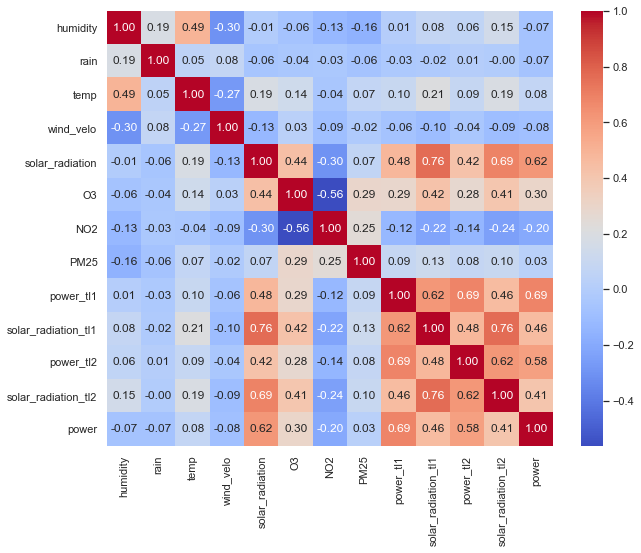

In [46]:
# correlation matrix between numerical values
g = sns.heatmap(df[['humidity', 'rain', 'temp', 'wind_velo', 'solar_radiation', 'O3', 'NO2',
       'PM25', 'power_tl1', 'solar_radiation_tl1', 'power_tl2',
       'solar_radiation_tl2', 'power'
                   ]].corr(), annot=True, fmt ='.2f', cmap='coolwarm')

fig = plt.gcf()
fig.set_size_inches(10,8)
plt.show()

### 3-5. Dataset Split 

In [47]:
# 트레인 테스트 나누기 7:3
X = df.drop(columns=['power'])
y = df['power']

# 셔플링 없이
train_X = X[:3811]
test_X = X[3811:]
train_y = y[:3811]
test_y = y[3811:]

#train_X, test_X, train_y, test_y = train_test_split(X, y, test_size =0.4, random_state=777)

## 4. Modeling

### 4-1. Linear Regression

In [48]:
# test셋 모델링 및 결과 확인
model = LinearRegression()
model.fit(train_X, train_y)

# print coefficients
print(pd.DataFrame({'Predictor': X.columns, 'coefficient':model.coef_}))

# print performance measures (training data)
regressionSummary(train_y, model.predict(train_X))

              Predictor   coefficient
0              humidity -8.538087e+01
1                  rain -2.277382e+02
2                  temp  3.562802e+01
3             wind_velo -6.215883e+01
4       solar_radiation  8.253440e+02
5                    O3 -4.634164e+01
6                   NO2 -1.462469e+02
7                  PM25 -8.406278e+01
8             power_tl1  5.727261e+02
9   solar_radiation_tl1 -2.870525e+02
10            power_tl2  1.665533e+02
11  solar_radiation_tl2 -8.185305e+01
12               hour_6 -1.491023e+14
13               hour_7 -1.491023e+14
14               hour_8 -1.491023e+14
15               hour_9 -1.491023e+14
16              hour_10 -1.491023e+14
17              hour_11 -1.491023e+14
18              hour_12 -1.491023e+14
19              hour_13 -1.491023e+14
20              hour_14 -1.491023e+14
21              hour_15 -1.491023e+14
22              hour_16 -1.491023e+14
23              hour_17 -1.491023e+14
24              hour_18 -1.491023e+14
25          

In [49]:
# Summary 결과 보기
train_df = train_X.join(train_y)
predictors = train_X.columns
formula = 'power ~ ' + ' + '.join(predictors)

linear_reg = sm.ols(formula=formula, data=train_df).fit()
linear_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  power   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     220.8
Date:                Sat, 12 Dec 2020   Prob (F-statistic):               0.00
Time:                        08:43:58   Log-Likelihood:                -25822.
No. Observations:                3811   AIC:                         5.173e+04
Df Residuals:                    3768   BIC:                         5.200e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             198.9932     22.957      8.668      0.000     153.983     244.003
humidity              -85.3413     23.398     -3.647      0.000    -131.215     -39.468
rain                 -228.0845    117.531     -1.941      0.052    -458.514       2.345
temp                   35.6446     32.411      1.100      0.271     -27.899      99.189
wind_velo             -62.2224     33.397     -1.863      0.063    -127.701       3.256
solar_radiation       825.2250     24.887     33.159      0.000     776.431     874.019
O3                    -46.1482     39.814     -1.159      0.246    -124.207      31.911
NO2                  -146.1387     36.366     -4.019      0.000    -217.438     -74.840
PM25                  -84.1666     35.415     -2.377      0.018    -153.601     -14.733
power_tl1             572.6707     31.381     18.249      0.000     511.144     634.197
solar_radiation_tl1  -287.0494     27.539    -10.423      0.000    -341.043    -233.056
power_tl2             166.4264     30.836      5.397      0.000     105.970     226.883
solar_radiation_tl2   -81.8011     26.741     -3.059      0.002    -134.229     -29.374
hour_6                -99.2699     17.042     -5.825      0.000    -132.682     -65.858
hour_7                -76.5916     15.954     -4.801      0.000    -107.871     -45.313
hour_8                  0.9116     14.313      0.064      0.949     -27.151      28.974
hour_9                134.6581     13.800      9.758      0.000     107.601     161.715
hour_10               290.5947     15.841     18.345      0.000     259.537     321.652
hour_11               -79.6753     15.323     -5.200      0.000    -109.717     -49.633
hour_12              -121.6732     16.752     -7.263      0.000    -154.517     -88.830
hour_13              -128.7482     17.346     -7.422      0.000    -162.757     -94.739
hour_14              -109.3017     16.450     -6.644      0.000    -141.554     -77.049
hour_15               193.1302     15.558     12.413      0.000     162.627     223.633
hour_16               212.0372     14.836     14.292      0.000     182.949     241.125
hour_17               134.4594     14.039      9.577      0.000     106.934     161.985
hour_18                -2.7817     14.534     -0.191      0.848     -31.278      25.714
hour_19               -68.9261     15.725     -4.383      0.000     -99.756     -38.096
hour_20               -79.8302     16.240     -4.916      0.000    -111.670     -47.990
season_1               19.9733     13.602      1.468      0.142      -6.694      46.641
season_2                1.9365     20.497      0.094      0.925     -38.250      42.123
season_3              -24.1324     23.512     -1.026      0.305     -70.229      21.964
wind_direction_2       13.2377     15.110      0.876      0.381     -16.387      42.862
win

In [50]:
# 예측값, 실제값 일부 확인 
power_lm_pred = model.predict(test_X)
result = pd.DataFrame({'Predicted': power_lm_pred, 'Actual':test_y, 'Residual': test_y - power_lm_pred})
print(result.head(50))

# test셋 결과 확인
regressionSummary(test_y, power_lm_pred)

      Predicted  Actual   Residual
3811  -31.34375      40   71.34375
3812  112.78125     182   69.21875
3813  365.28125     256 -109.28125
3814  447.56250     247 -200.56250
3815  105.68750     288  182.31250
3816   91.46875     260  168.53125
3817  -38.12500     310  348.12500
3818   31.15625     311  279.84375
3819  292.71875     268  -24.71875
3820  300.75000     223  -77.75000
3821  345.62500      85 -260.62500
3822  107.50000      16  -91.50000
3823  -33.25000       0   33.25000
3824  -40.03125       0   40.03125
3825  -76.00000       0   76.00000
3826  -21.50000      20   41.50000
3827  169.81250     283  113.18750
3828  356.21875     522  165.78125
3829  525.46875     729  203.53125
3830  245.93750     349  103.06250
3831  180.62500     313  132.37500
3832  152.25000     308  155.75000
3833  155.62500     313  157.37500
3834  375.37500     212 -163.37500
3835  360.15625      67 -293.15625
3836  263.62500      50 -213.62500
3837   66.75000       7  -59.75000
3838  -29.28125     

In [51]:
prediction = model.predict(test_X)
mse = np.sqrt(mean_squared_error(prediction, test_y))
print('RMSE of LinearRegression is %.2f' %mse)

RMSE of LinearRegression is 220.12


0.769889840881273


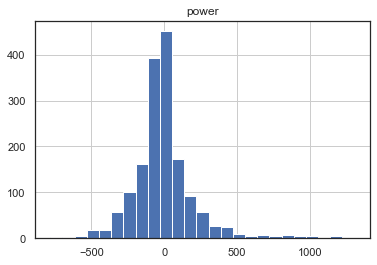

In [53]:
# 잔차 정규성 확인
power_lm_pred = model.predict(test_X)
all_residuals = test_y - power_lm_pred
# Determine the percentage of datapoints with a residual in [-200, 200] = approx.
# 75%
print(len(all_residuals[(all_residuals > -200) & (all_residuals < 200)]) / len(all_residuals))
pd.DataFrame(all_residuals).hist(bins=25)
plt.show()

### 4-2. Decision Tree

In [136]:
dt_reg = DecisionTreeRegressor(random_state=777, max_depth=4)
dt_reg.fit(train_X, train_y)

prediction = dt_reg.predict(test_X)
rmse = np.sqrt(mean_squared_error(prediction, test_y))
print('RMSE of Decision Tree is ', rmse)

RMSE of Decision Tree is  200.80445592825828


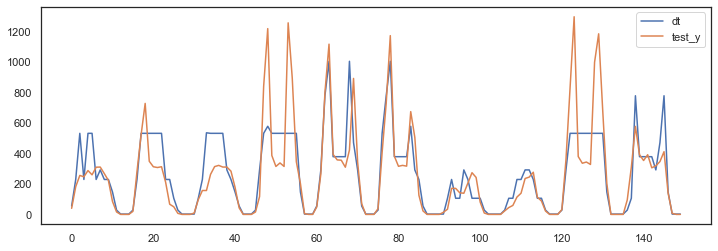

In [114]:
# 그래프 그려보기 

# 예측값
pd.Series(prediction)[0:150].plot()
#pd.Series(prediction_rfr)[20:50].plot()


#실제값
## 인덱스 없애기
graph_test_y = test_y.reset_index(drop=True)
graph_test_y[0:150].plot()
# 에러 abs(pd.Series(prediction_xgr) - graph_test_y)[100:130].plot()
plt.legend(['dt','test_y', 'error'])

fig = plt.gcf()
fig.set_size_inches(12,4)
plt.show()

In [137]:
prediction = dt_reg.predict(train_X)
rmse = np.sqrt(mean_squared_error(prediction, train_y))
print('RMSE of Decision Tree is ', rmse)

RMSE of Decision Tree is  211.2069309724856


### 4-3. RandomForest

In [138]:
rt_reg = RandomForestRegressor(random_state=777, n_estimators=800)
rt_reg.fit(train_X, train_y)

prediction = rt_reg.predict(test_X)
rmse = np.sqrt(mean_squared_error(prediction, test_y))
print('RMSE of RandomForest is ', rmse)

RMSE of RandomForest is  180.70260308642557


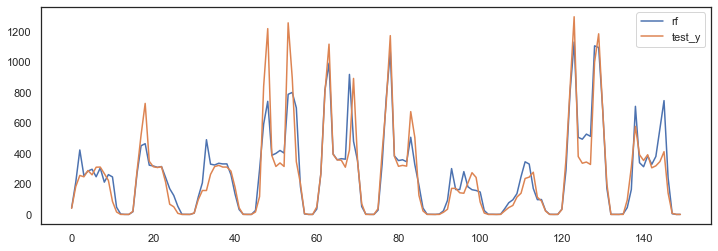

In [116]:
# 그래프 그려보기 

# 예측값
pd.Series(prediction)[0:150].plot()
#pd.Series(prediction_rfr)[20:50].plot()


#실제값
## 인덱스 없애기
graph_test_y = test_y.reset_index(drop=True)
graph_test_y[0:150].plot()
# 에러 abs(pd.Series(prediction_xgr) - graph_test_y)[100:130].plot()
plt.legend(['rf','test_y', 'error'])

fig = plt.gcf()
fig.set_size_inches(12,4)
plt.show()

In [139]:
prediction = rt_reg.predict(train_X)
rmse = np.sqrt(mean_squared_error(prediction, train_y))
print('RMSE of RandomForest is ', rmse)

RMSE of RandomForest is  62.54909631194334


### 4-4. SVM (LinearSVR)

In [140]:
svm_reg = LinearSVR(C = 1.0, epsilon=1.5, random_state=777)
#svm_reg = SVR(kernel ='rbf')
svm_reg.fit(train_X, train_y)


prediction = svm_reg.predict(test_X)
rmse = np.sqrt(mean_squared_error(prediction, test_y))
print('RMSE of SVM is ', rmse)

RMSE of SVM is  273.05249694423804


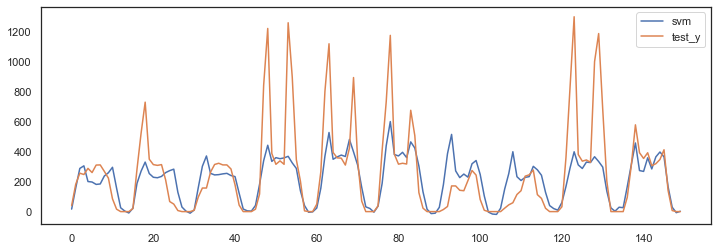

In [118]:
# 그래프 그려보기 

# 예측값
pd.Series(prediction)[0:150].plot()
#pd.Series(prediction_rfr)[20:50].plot()


#실제값
## 인덱스 없애기
graph_test_y = test_y.reset_index(drop=True)
graph_test_y[0:150].plot()
# 에러 abs(pd.Series(prediction_xgr) - graph_test_y)[100:130].plot()
plt.legend(['svm','test_y', 'error'])

fig = plt.gcf()
fig.set_size_inches(12,4)
plt.show()

In [64]:
prediction = svm_reg.predict(train_X)
rmse = np.sqrt(mean_squared_error(prediction, train_y))
print('RMSE of SVM is ', rmse)

RMSE of SVM is  291.2851721943329


### 4-5. XGBoost

In [122]:
#번외 순서대로 보고 싶어서
train_X = X[:3811]
test_X = X[3811:]
train_y = y[:3811]
test_y = y[3811:]

In [119]:
xgb_reg = xg.XGBRegressor(random_state=777,n_estimators=1000,learning_rate=0.1, n_jobs=-1)
# xgb_reg.fit(train_X, train_y,early_stopping_rounds=5, eval_set=[(test_X, test_y)], verbose=False)

xgb_reg.fit(train_X, train_y)



prediction = xgb_reg.predict(test_X)
rmse = np.sqrt(mean_squared_error(prediction, test_y))
print('RMSE of XGBoost is ', rmse)

RMSE of XGBoost is  190.8593361734224


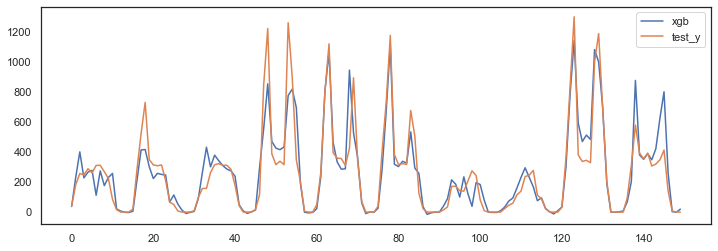

In [121]:
# 그래프 그려보기 

# 예측값
pd.Series(prediction)[0:150].plot()
#pd.Series(prediction_rfr)[20:50].plot()


#실제값
## 인덱스 없애기
graph_test_y = test_y.reset_index(drop=True)
graph_test_y[0:150].plot()
# 에러 abs(pd.Series(prediction_xgr) - graph_test_y)[100:130].plot()
plt.legend(['xgb','test_y', 'error'])

fig = plt.gcf()
fig.set_size_inches(12,4)
plt.show()

In [141]:
prediction = xgb_reg.predict(train_X)
rmse = np.sqrt(mean_squared_error(prediction, train_y))
print('RMSE of XGBoost is ', rmse)

RMSE of XGBoost is  3.4571921893965665


### 4-6. AdaBoost

In [142]:
adb_reg=AdaBoostRegressor(n_estimators=600,random_state=777,learning_rate=0.1)
adb_reg.fit(train_X, train_y)


prediction = adb_reg.predict(test_X)
rmse = np.sqrt(mean_squared_error(prediction, test_y))
print('RMSE of AdaBoost is ', rmse)

RMSE of AdaBoost is  240.7088784032468


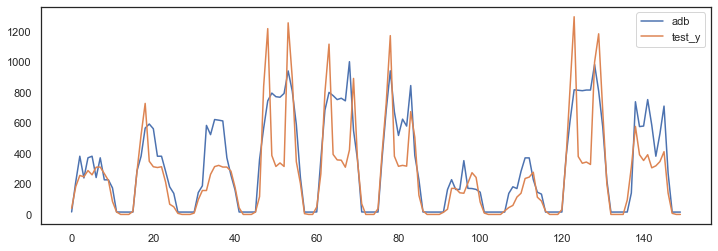

In [123]:
# 그래프 그려보기 

# 예측값
pd.Series(prediction)[0:150].plot()
#pd.Series(prediction_rfr)[20:50].plot()


#실제값
## 인덱스 없애기
graph_test_y = test_y.reset_index(drop=True)
graph_test_y[0:150].plot()
# 에러 abs(pd.Series(prediction_xgr) - graph_test_y)[100:130].plot()
plt.legend(['adb','test_y', 'error'])

fig = plt.gcf()
fig.set_size_inches(12,4)
plt.show()

In [97]:
prediction = adb_reg.predict(train_X)
rmse = np.sqrt(mean_squared_error(prediction, train_y))
print('RMSE of AdaBoost is ', rmse)

RMSE of AdaBoost is  230.65638257720755


### 4-7. Neural Network

In [143]:
NN_reg = MLPRegressor(random_state=777, hidden_layer_sizes=(100,100), max_iter=500)
NN_reg.fit(train_X, train_y)

prediction = NN_reg.predict(test_X)
rmse = np.sqrt(mean_squared_error(prediction, test_y))
print('RMSE of Neural Network is ', rmse)

RMSE of Neural Network is  215.34778432152734


/Users/jin/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


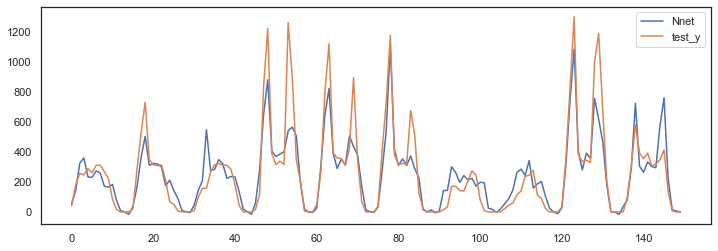

In [125]:
# 그래프 그려보기 

# 예측값
pd.Series(prediction)[0:150].plot()
#pd.Series(prediction_rfr)[20:50].plot()


#실제값
## 인덱스 없애기
graph_test_y = test_y.reset_index(drop=True)
graph_test_y[0:150].plot()
# 에러 abs(pd.Series(prediction_xgr) - graph_test_y)[100:130].plot()
plt.legend(['Nnet','test_y', 'error'])

fig = plt.gcf()
fig.set_size_inches(12,4)
plt.show()

In [144]:
prediction = NN_reg.predict(train_X)
np.sqrt(mean_squared_error(prediction, train_y))
print('RMSE of Neural Network is ', rmse)

RMSE of Neural Network is  215.34778432152734


### 4-8. Cross Validation
- k=10, 전체 데이터로 수행

In [103]:
# Kfold = 10
Kfold = StratifiedKFold(n_splits=10)

In [104]:
df.head()

,humidity,rain,temp,wind_velo,solar_radiation,O3,NO2,PM25,power_tl1,solar_radiation_tl1,power_tl2,solar_radiation_tl2,power,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,season_1,season_2,season_3,wind_direction_2,wind_direction_3,wind_direction_4,wind_direction_5,wind_direction_6,wind_direction_7,wind_direction_8,sky_con_2,sky_con_3,sky_con_4,rain_type_1,rain_type_2,rain_type_3
0,0.293478,0.0,0.335586,0.227723,0.000000,0.200000,0.1250,0.123711,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0.347826,0.0,0.313063,0.158416,0.000000,0.155555,0.2125,0.113402,0.000000,0.000000,0.000000,0.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0.391304,0.0,0.274775,0.089109,0.002506,0.140741,0.2625,0.123711,0.002565,0.002506,0.003592,0.002506,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0.315217,0.0,0.270270,0.168317,0.092732,0.125926,0.3000,0.123711,0.094920,0.067669,0.125705,0.097744,216,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
4,0.260870,0.0,0.277027,0.227723,0.240601,0.111111,0.3250,0.123711,0.277065,0.190476,0.398153,0.253133,751,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [105]:
X = df.drop('power', axis=1)
y = df['power']

/Users/jin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
/Users/jin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
/Users/jin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
/Users/jin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


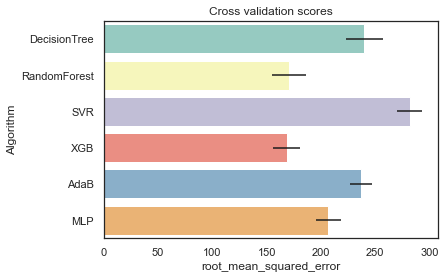

In [106]:
random_state = 777
Regressors = []
Regressors.append(DecisionTreeRegressor(random_state=random_state))
Regressors.append(RandomForestRegressor(random_state=random_state))
Regressors.append(LinearSVR(C = 1.0, epsilon=1.5, random_state=random_state))
Regressors.append(xg.XGBRegressor(n_estimators=900,learning_rate=0.1))
Regressors.append(AdaBoostRegressor(n_estimators=1000,random_state=random_state,learning_rate=0.1))
Regressors.append(MLPRegressor(random_state=random_state, max_iter=500))

cv_results = []
for regressor in Regressors :
    cv_results.append(cross_val_score(regressor, X, y = y, scoring = "neg_mean_squared_error", cv = Kfold, n_jobs=-1))
    
cv_means = []
cv_std = []

# neg_mean_squared_error 라서 변환 
cv_results = np.abs(cv_results)
cv_results = np.sqrt(cv_results)

for cv_result in cv_results:
    
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())


cv_res = pd.DataFrame({"CrossValMeans":cv_means,
                       "CrossValerrors": cv_std,
                       "Algorithm":["DecisionTree","RandomForest","SVR","XGB","AdaB","MLP"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("root_mean_squared_error")
g = g.set_title("Cross validation scores")    

### 4-9. Parameter Tuning
    4-9-1. RandomForest
    4-9-2. XGboost

#### 4-9-1. RandomForest

In [107]:
random_state = 777
# RFR Parameters tunning 
RFR = RandomForestRegressor(random_state=random_state)


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [8, 10, 12],
              "max_features": [7, 9, 10, 12], #데이터에서 참조할 피처의 수
              "min_samples_split": [2, 3, 5, 10], #노드를 분할하기 위한 최소한의 데이터 수
              "min_samples_leaf": [1, 3, 5, 10], #리프 노드가 되기 위한 최소한의 샘플 데이터 수 
              "bootstrap": [False, True], 
              "n_estimators" :[1000,1100,1200], #결정트리 갯수 
              "criterion": ["mse"]}


gsRFR = GridSearchCV(RFR,param_grid = rf_param_grid, cv=Kfold, scoring="neg_mean_squared_error", n_jobs= -1, verbose = 1)

gsRFR.fit(train_X,train_y)

RFR_best = gsRFR.best_estimator_

# Best score
bestscore = math.sqrt(abs(gsRFR.best_score_))
print("The best score is ", bestscore)
print("The best model is ", RFR_best)

Fitting 10 folds for each of 1152 candidates, totalling 11520 fits


/Users/jin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed: 40.1min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed: 51.3min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | e

The best score is  173.62089433605175
The best model is  RandomForestRegressor(bootstrap=False, max_depth=12, max_features=12,
                      min_samples_split=3, n_estimators=1000, random_state=777)


In [126]:
# test셋 결과
prediction_rfr = RFR_best.predict(test_X)
rmse = np.sqrt(mean_squared_error(prediction_rfr, test_y))
print('RMSE of Best RandomForest Model is %.2f' %rmse)

RMSE of Best RandomForest Model is 183.35


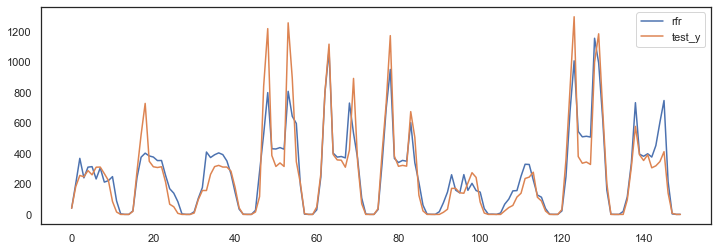

In [146]:
# 그래프 그려보기 

# 예측값
# pd.Series(prediction)[100:140].plot()
pd.Series(prediction_rfr)[0:150].plot()


#실제값
## 인덱스 없애기
graph_test_y = test_y.reset_index(drop=True)
graph_test_y[0:150].plot()
#에러 
#abs(pd.Series(prediction_rfr) - graph_test_y)[0:150].plot()
plt.legend(['rfr','test_y', 'error'])

fig = plt.gcf()
fig.set_size_inches(12,4)
plt.show()

In [80]:
# test셋 결과
prediction_rfr = RFR_best.predict(train_X)
rmse = np.sqrt(mean_squared_error(prediction_rfr, train_y))
print('RMSE of Best RandomForest Model is %.2f' %rmse)

RMSE of Best RandomForest Model is 127.32


### 4-9-2. XGBoost

In [110]:
# XGR Parameters tunning  
XGR = xg.XGBRegressor()


## Search grid for optimal parameters
xgb_param_grid = {"n_estimators" :list(range(800,1100,100)),  # 결정트리수 
                 "learning_rate":[0.05,0.09,0.1,0.15,0.2]} #러닝레이트

gsXGR = GridSearchCV(XGR,param_grid = xgb_param_grid, cv=Kfold, scoring="neg_mean_squared_error", n_jobs= -1, verbose = 1)
gsXGR.fit(train_X,train_y)

XGR_best = gsXGR.best_estimator_

# Best score
bestscore = math.sqrt(abs(gsXGR.best_score_))
print("The best score is ", bestscore)
print("The best model is ", XGR_best)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


/Users/jin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.2min finished


The best score is  166.83835912421634
The best model is  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=800, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [145]:
prediction_xgr = XGR_best.predict(test_X)
rmse = np.sqrt(mean_squared_error(prediction_xgr, test_y))
print('RMSE of Best XGBoost Model is %.2f' %rmse)

RMSE of Best XGBoost Model is 190.83


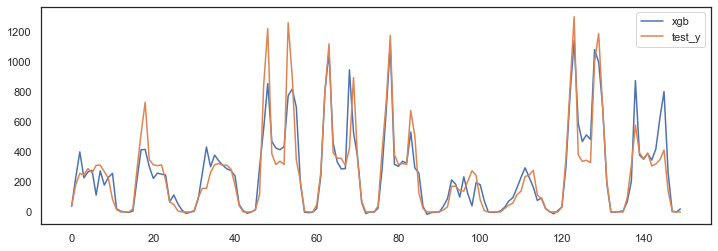

In [147]:
# 그래프 그려보기 

# 예측값
pd.Series(prediction_xgr)[0:150].plot()
#pd.Series(prediction_rfr)[20:50].plot()


#실제값
## 인덱스 없애기
graph_test_y = test_y.reset_index(drop=True)
graph_test_y[0:150].plot()
# 에러 abs(pd.Series(prediction_xgr) - graph_test_y)[100:130].plot()
plt.legend(['xgb','test_y', 'error'])

fig = plt.gcf()
fig.set_size_inches(12,4)
plt.show()

In [631]:
prediction_xgr = XGR_best.predict(train_X)
rmse = np.sqrt(mean_squared_error(prediction_xgr, train_y))
print('RMSE of Best XGBoost Model is %.2f' %rmse)

RMSE of Best XGBoost Model is 110.61


## Feature Importances

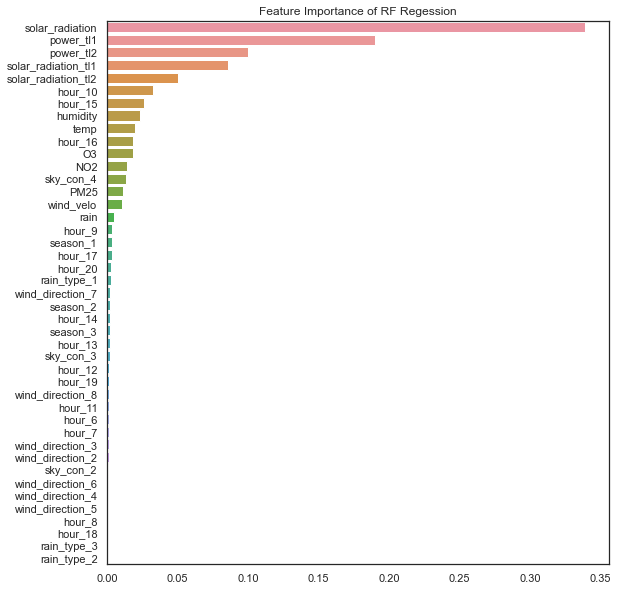

In [131]:
rf_feature_series = pd.Series(data = RFR_best.feature_importances_, index=train_X.columns)
rf_feature_series = rf_feature_series.sort_values(ascending=False)
sns.barplot(x=rf_feature_series, y=rf_feature_series.index).set_title('Feature Importance of RF Regession')

fig = plt.gcf()
fig.set_size_inches(9,10)
plt.show()

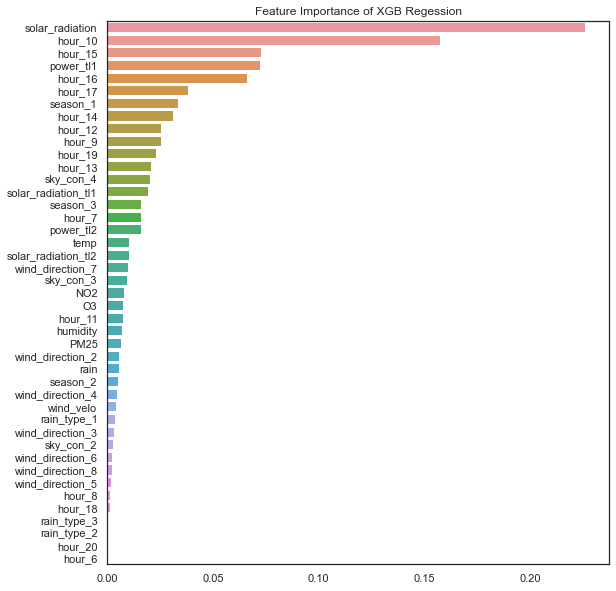

In [148]:
xgb_feature_series = pd.Series(data = XGR_best.feature_importances_, index=train_X.columns)
xgb_feature_series = xgb_feature_series.sort_values(ascending=False)
sns.barplot(x=xgb_feature_series, y=xgb_feature_series.index).set_title('Feature Importance of XGB Regession')

fig = plt.gcf()
fig.set_size_inches(9,10)
plt.show()

## 예측값과 실제값 그래프로 그려보기

In [133]:
# 그래프 그리는 함수
def make_graph(pred, real, num1, num2):
    pd.Series(pred)[num1:num2].plot()
    
    graph_test_y = real.reset_index(drop=True)
    graph_test_y[num1:num2].plot()
    # 에러 abs(pd.Series(prediction_xgr) - graph_test_y)[100:130].plot()
    # plt.legend(['xgb','test_y', 'error'])
    fig = plt.gcf()
    fig.set_size_inches(12,4)
    return plt.show()

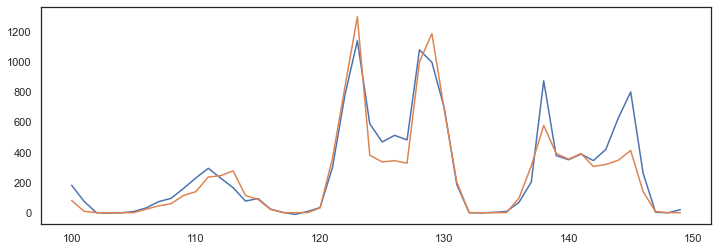

In [134]:
make_graph(prediction_xgr, test_y, 100,150)

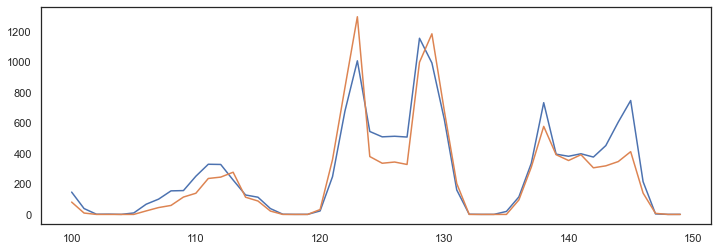

In [135]:
make_graph(prediction_rfr, test_y, 100,150)